In [1]:
from google.colab import files
uploaded = files.upload()

Saving smartLeaf_mobilenetV2.keras to smartLeaf_mobilenetV2.keras


In [3]:
from tensorflow.keras.models import load_model

# If uploaded manually:
model = load_model('smartLeaf_mobilenetV2.keras')

# OR from Google Drive path:
# model = load_model(model_path)


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
drive.mount('/content/drive')
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/content/drive/My Drive/Colab Notebooks/Data/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

Mounted at /content/drive
Found 1301 images belonging to 14 classes.


In [9]:
!pip install git+https://github.com/keisen/tf-keras-vis.git


  Cloning https://github.com/keisen/tf-keras-vis.git to /tmp/pip-req-build-kh0_0l4g
  Running command git clone --filter=blob:none --quiet https://github.com/keisen/tf-keras-vis.git /tmp/pip-req-build-kh0_0l4g
  Resolved https://github.com/keisen/tf-keras-vis.git to commit 8bb8392ae5894c91acdfacaa898088c6b0c7a522
  Preparing metadata (setup.py) ... done
  Created wheel for tf-keras-vis: filename=tf_keras_vis-0.8.8-py3-none-any.whl size=52701 sha256=f3a7aa828cbd84e06a22cd5eef2b995486f1902027ff74ebcefcd25607af189d
  Stored in directory: /tmp/pip-ephem-wheel-cache-xyov23bq/wheels/47/ff/fc/f64cc44b632aa7275f2dd5938b6e929c5edaa0eb19a7353597
Successfully built tf-keras-vis


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

def show_gradcam(model, val_gen, layer_name='block_12_expand_relu', n_images=5):
    model_modifier = ReplaceToLinear()
    gradcam = Gradcam(model, model_modifier=model_modifier)

    images, labels = next(iter(val_gen))  # Get one batch
    for i in range(min(n_images, len(images))):
        image = images[i]
        label = int(labels[i])
        score = CategoricalScore([label])

        cam = gradcam(score, np.array([image]), penultimate_layer=layer_name)
        heatmap = cam[0]

        # Plot
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.imshow(heatmap, cmap='jet', alpha=0.5)
        plt.title(f'Grad-CAM | True Class: {label}')
        plt.axis('off')
        plt.show()


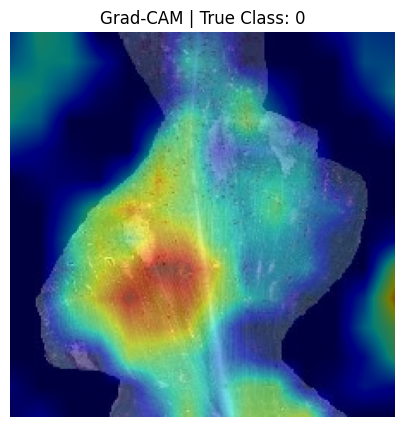

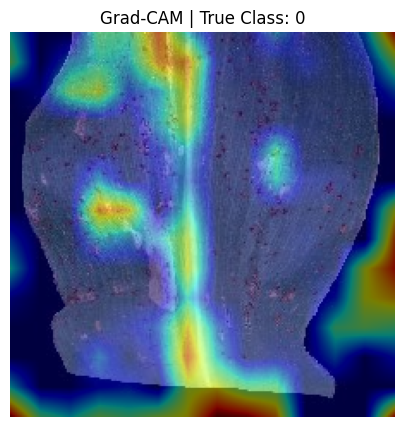

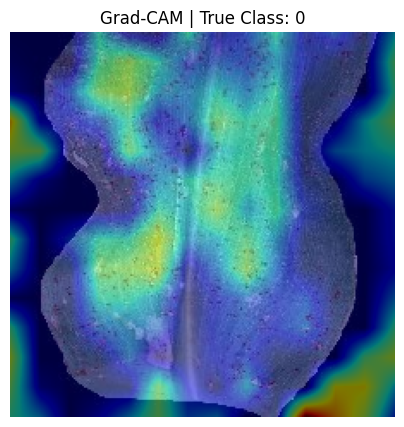

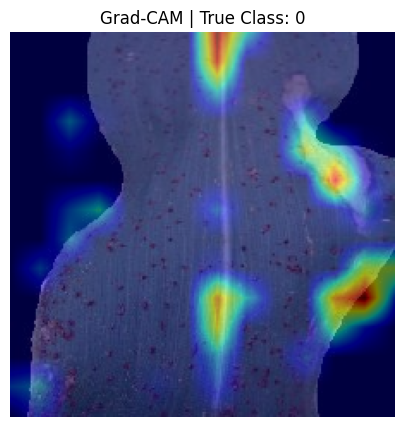

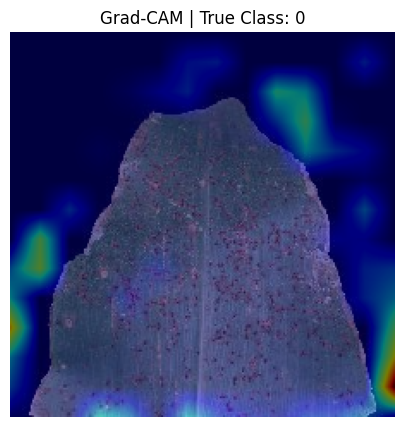

In [11]:
show_gradcam(model, val_gen, layer_name='block_12_expand_relu', n_images=5)

In [13]:
#from tf_keras_vis import ActivationMaximization
#visualize_activations(model, layer_name='block_12_expand_relu') --> This is the old one,  now we use gradcam which is up

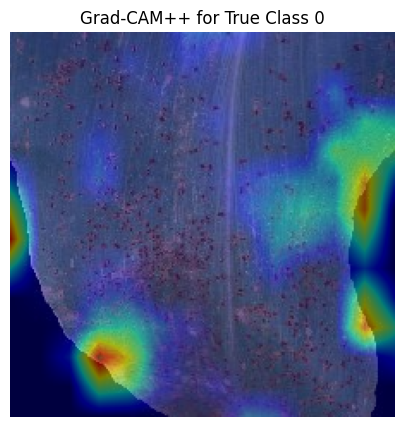

In [15]:
#penultimate_layer='block_12_expand_relu' is a MobileNetV2 layer — others can be replaced, such as 'Conv_1_relu' or 'block_16_project'.

#ReplaceToLinear() changes the last layer’s activation from softmax to linear just for visualization — it doesn't modify the model permanently.

import numpy as np
import matplotlib.pyplot as plt

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Replace softmax with linear to make gradients flow better
model_modifier = ReplaceToLinear()

# Create Grad-CAM++ object
gradcam = GradcamPlusPlus(model, model_modifier=model_modifier)

# Get one sample from the validation set
images, labels = next(iter(val_gen))
image = images[0]
true_label = int(labels[0])  # Use the actual label for scoring

# Score function to highlight the correct class
score = CategoricalScore([true_label])

# Generate CAM
cam = gradcam(score, np.array([image]), penultimate_layer='block_12_expand_relu')

# Plot with heatmap
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.imshow(cam[0], cmap='jet', alpha=0.5)  # Overlay
plt.title(f'Grad-CAM++ for True Class {true_label}')
plt.axis('off')
plt.show()

Found 151 misclassified samples out of 1301


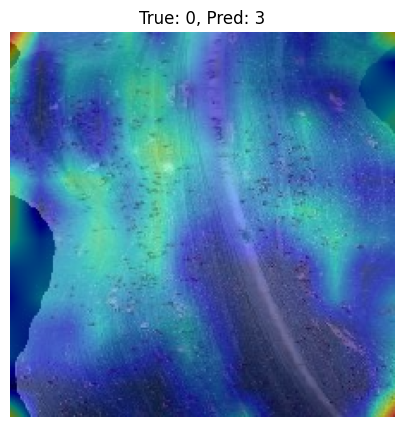

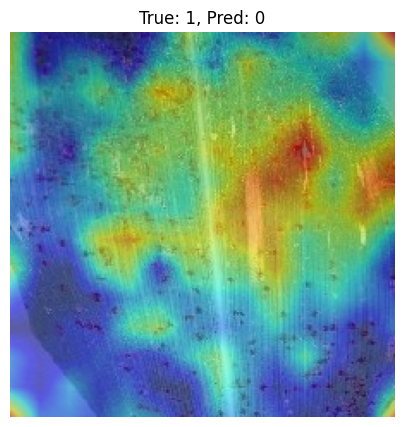

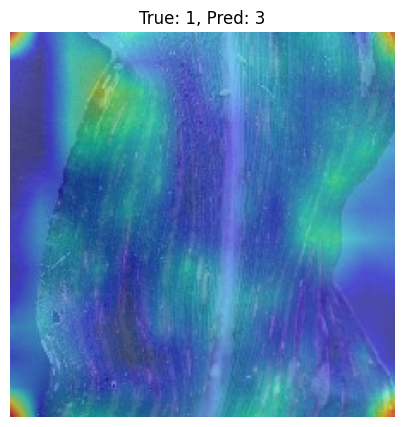

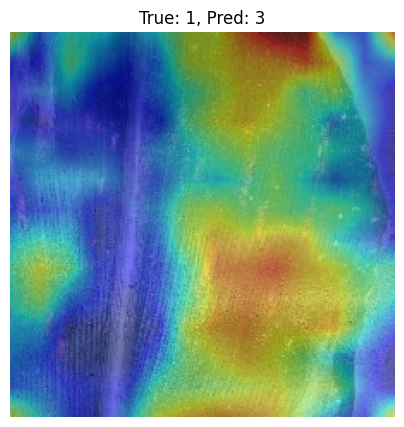

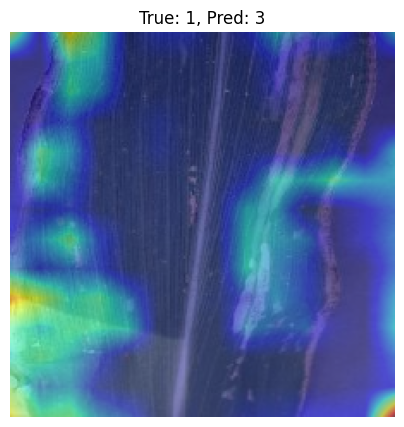

In [16]:
#Grad-CAM heatmaps showing where the model was “looking” when it made the wrong decision.
#Helpful for debugging mislabeled samples, low-quality images, or misleading features.

import numpy as np
import matplotlib.pyplot as plt

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from sklearn.metrics import accuracy_score

# Prepare model modifier
model_modifier = ReplaceToLinear()
gradcam = GradcamPlusPlus(model, model_modifier=model_modifier)

# Step 1: Get all validation data
val_images = []
val_labels = []

for i in range(len(val_gen)):
    images, labels = val_gen[i]
    val_images.extend(images)
    val_labels.extend(labels)

val_images = np.array(val_images)
val_labels = np.array(val_labels).astype(int)

# Step 2: Predict
y_pred_probs = model.predict(val_images, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 3: Find misclassified indices
misclassified_idx = np.where(y_pred != val_labels)[0]

print(f"Found {len(misclassified_idx)} misclassified samples out of {len(val_labels)}")

# Step 4: Show Grad-CAM++ for first few wrong predictions
for i, idx in enumerate(misclassified_idx[:5]):  # Show first 5 mistakes
    img = val_images[idx]
    true_label = val_labels[idx]
    predicted_label = y_pred[idx]

    # Score the predicted (wrong) class to see why model thought that
    score = CategoricalScore([predicted_label])

    # Generate CAM
    cam = gradcam(score, np.array([img]), penultimate_layer='block_12_expand_relu')

    # Plot
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.imshow(cam[0], cmap='jet', alpha=0.5)
    plt.title(f"True: {true_label}, Pred: {predicted_label}")
    plt.axis('off')
    plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_1
Received: inputs=['Tensor(shape=(1, 224, 224, 3))']
  warnings.warn(msg)


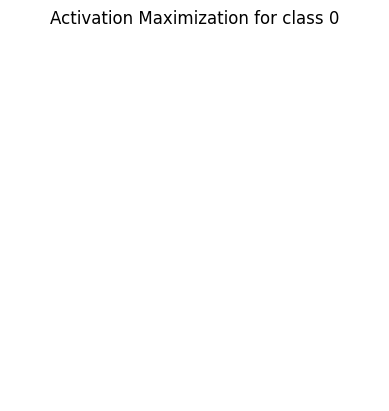

In [27]:
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
import matplotlib.pyplot as plt
import numpy as np

# Replace activations with linear for smooth gradients
model_modifier = ReplaceToLinear()

# Create ActivationMaximization object with model and modifier
activation_maximization = ActivationMaximization(model, model_modifier=model_modifier)

class_idx = 0

# Define score function - returns the model output score for target class
def score(output):
    return output[:, class_idx]

# Call activation maximization with score function (first arg)
generated_images = activation_maximization(score, steps=100)

img = np.clip(generated_images[0], 0, 1)

plt.imshow(img)
plt.axis('off')
plt.title(f'Activation Maximization for class {class_idx}')
plt.show()
